# __Machine Learning for Prioritizing Blood Pressure Genes__ 

## Import modules:

In [1]:
import pandas as pd
import numpy as np
from numpy import sort
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

from sklearn import datasets, metrics, preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score,  cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, max_error
from sklearn.datasets import make_classification, load_digits
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from missingpy import MissForest

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectFromModel 

from sklearn.cross_decomposition import PLSRegression
from sys import stdout

from sklearn.inspection import permutation_importance

import shap

import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor


import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms

from boostaroota import BoostARoota

import seaborn as sns
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

import time
import dask_ml.model_selection as dcv

import matplotlib
import matplotlib.pyplot as plt

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import filterwarnings
filterwarnings("ignore")

seed = 7

C:\Users\Hannah\Anaconda3\envs\tensorflow_environment\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load data:

In [18]:
dataset= pd.read_csv('BP_training.txt', header=0)
data = dataset.drop(["Gene"],1)
print(data.shape)

(15021, 60)


# Data preprocessing
1. Impute missing values by mean imputation for individual features
2. Standardise each feature individually on a scale of 0-1
3. Convert BP gene labeling to scores for regression
4. Split into train and test datasets


In [19]:
df1 = data.iloc[:,0:59]

#### MissForest - Random forest imputation:

In [4]:
#Random forest imputer
imputer = MissForest()
df = imputer.fit_transform(df1)
#Standardising features indiviudally on 0-1 scale
X = MinMaxScaler().fit_transform(df)

Iteration: 0
Iteration: 1
Iteration: 2


In [5]:
#Converting labels to scores
data['BPCausality_encoded'] = data['BPCausality'].map( {'most likely':0.9, 'probable':0.7 , 'possible':0.40, 'least likely':0.1})
Y = data["BPCausality_encoded"] 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Building Models:
- Parameter tuning with randomgridsearchCV and dask parallel processing

In [20]:
lasso = Lasso(random_state=seed)
lasso_params =  {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                "max_iter": [100, 500, 1000]}

elastic = ElasticNet(random_state=seed, tol=1)
elastic_params = {
    "max_iter": [1000, 2500, 5000],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)}

dt = DecisionTreeRegressor(random_state=seed)
dt_params= {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

gbr = GradientBoostingRegressor(random_state=seed)
gbr_params = {
    "learning_rate": [0.001, 0.01, 0.1],
    "min_samples_split": [50, 100],
    "min_samples_leaf": [50, 100],
    "max_depth":[5, 10, 20]}
    
xgbr = xgboost.XGBRegressor(random_state=seed, objective='reg:squarederror') 
xgbr_params = {  
    "learning_rate": [0.001, 0.01, 0.1],
    "min_samples_leaf": [50, 100],
    "max_depth":[5, 10, 20],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3]}
    
rfr = RandomForestRegressor(random_state=seed)
rfr_params={'n_estimators':[100, 500, 1000], 
             'min_samples_split': [50, 100],
             'min_samples_leaf': [50, 100],} 

knr = KNeighborsRegressor()
knr_params = {
    'n_neighbors':[7,9,11,13,15,17],
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean','manhattan']}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

models = []

models.append(('XGBR', dcv.RandomizedSearchCV(xgbr, xgbr_params, cv=inner_cv, iid=False, n_jobs=-1))) 
models.append(('GBR', dcv.RandomizedSearchCV(gbr, gbr_params, cv=inner_cv,iid=False, n_jobs=-1)))
models.append(('RFR', dcv.RandomizedSearchCV(rfr, rfr_params, cv=inner_cv,iid=False, n_jobs=-1)))
models.append(('DT', dcv.RandomizedSearchCV(dt, dt_params, cv=inner_cv, iid=False, n_jobs=-1)))
models.append(('KNR', dcv.RandomizedSearchCV(knr, knr_params, cv=inner_cv, iid=False, n_jobs=-1)))
models.append(('Lasso', dcv.RandomizedSearchCV(lasso, lasso_params, cv=inner_cv, iid=False, n_jobs=-1)))
models.append(('ElasticNet', dcv.RandomizedSearchCV(elastic, elastic_params, cv=inner_cv, iid=False, n_jobs=-1)))

results = []
names = []
scoring = ['r2', 'neg_mean_squared_error', 'max_error', 'neg_mean_absolute_error'] #https://scikit-learn.org/stable/modules/model_evaluation.html


XGBR Nested CV results for all scores: 
 {'fit_time': array([110.90895247, 105.54169369, 153.41087675, 124.73115087,
       146.7573626 ]), 'score_time': array([0.0368607 , 0.05027509, 0.02208972, 0.02022266, 0.01495934]), 'test_r2': array([0.65916768, 0.81294171, 0.71140515, 0.72134827, 0.79021877]), 'test_neg_mean_squared_error': array([-0.00116484, -0.00095891, -0.00116795, -0.00185935, -0.00126645]), 'test_max_error': array([-0.74041381, -0.49793365, -0.62205925, -0.77243384, -0.56047053]), 'test_neg_mean_absolute_error': array([-0.00653283, -0.00565459, -0.0067845 , -0.00805052, -0.00587795])} 

XGBR r2 Nested CV Average 0.7390163147777429
XGBR MSE Nested CV Average -0.0012835016236985664
Best Parameters: 
{'reg_lambda': 1.3, 'reg_alpha': 1.3, 'min_samples_leaf': 50, 'max_depth': 5, 'learning_rate': 0.1}

Non-nested CV Results:
XGBR Train r2: 0.9220295999338871 Test r2: 0.7191426163655193
XGBR Train MSE: 0.00040467924029704926 Test MSE: 0.001280073557755515
XGBR Train Explained Va

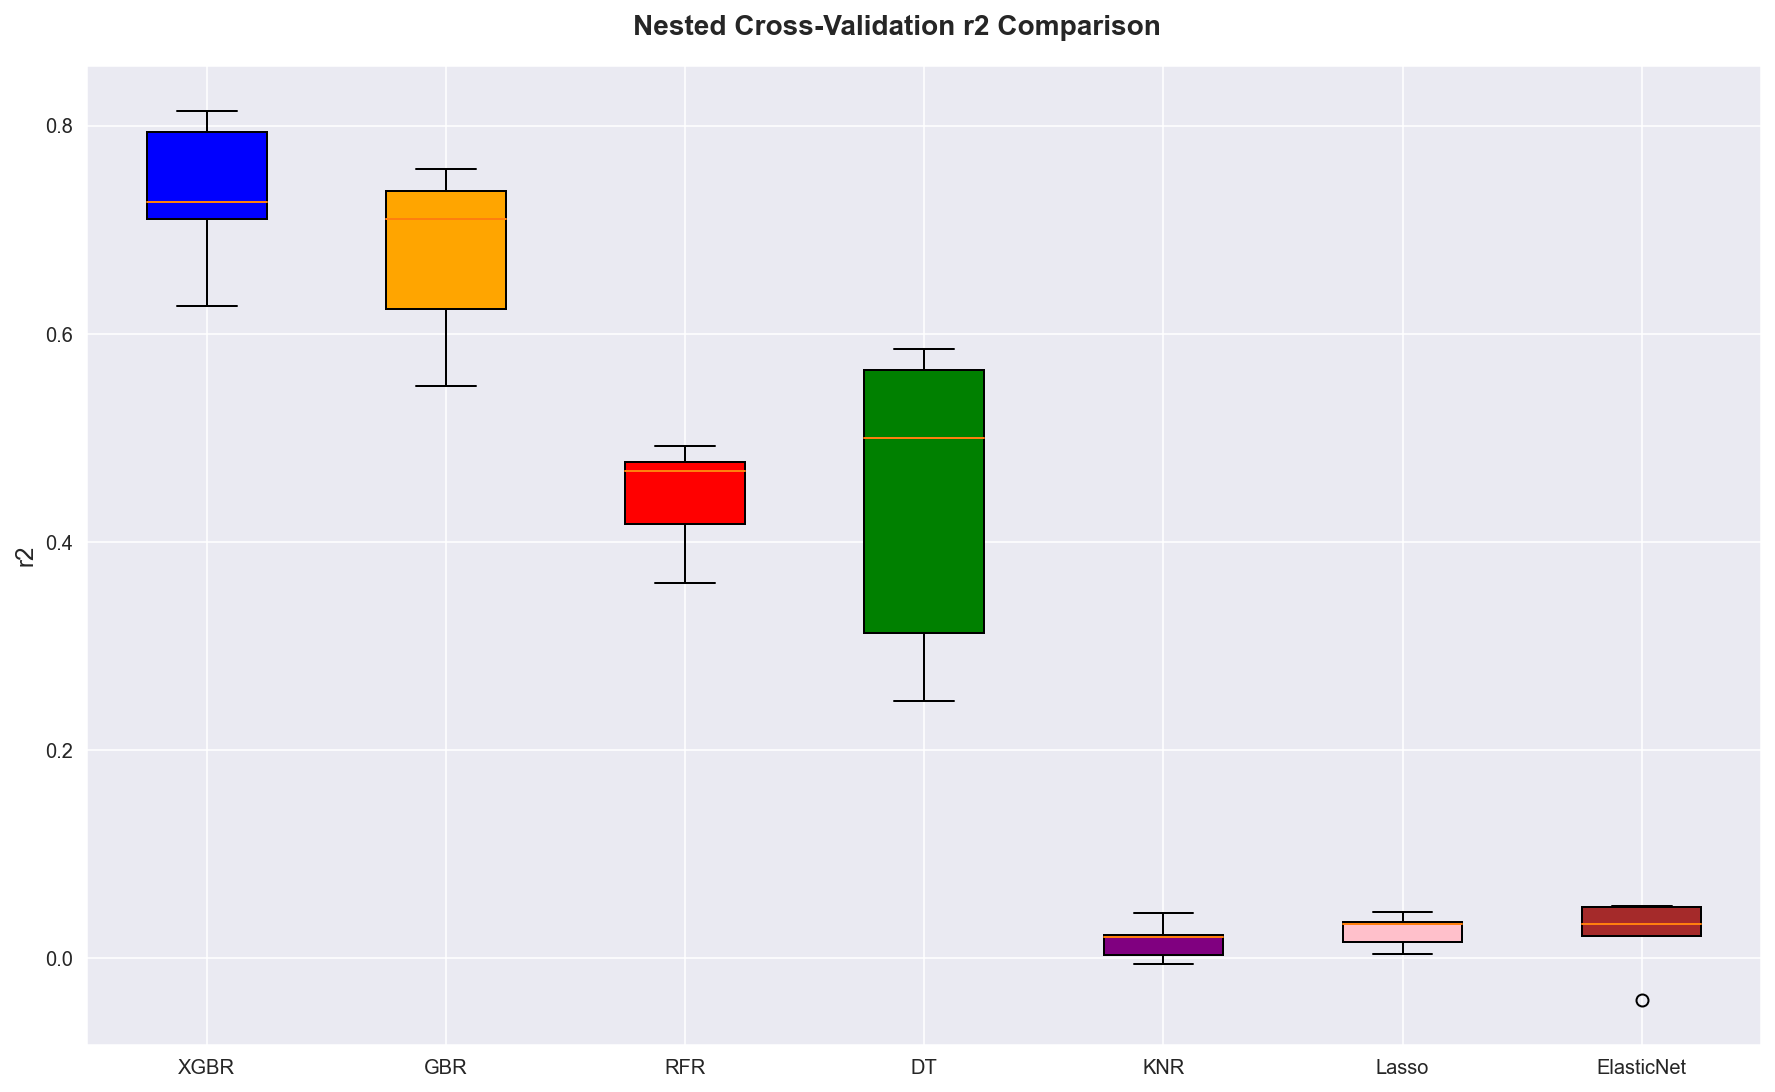

In [21]:
for name, model in models:
    nested_cv_results = model_selection.cross_validate(model, X, Y, cv=outer_cv, scoring=scoring)
    nested_cv_results2 = model_selection.cross_val_score(model, X, Y, cv=outer_cv, scoring='r2')
    results.append(nested_cv_results2)
    names.append(name)
    print(name, 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
    print(name, 'r2 Nested CV Average', np.mean(nested_cv_results['test_r2']))
    print(name, 'MSE Nested CV Average', np.mean(nested_cv_results['test_neg_mean_squared_error'] ))
    model.fit(X_train_boruta, Y_train_boruta)
    print("Best Parameters: \n{}\n".format(model.best_params_))
    print('Non-nested CV Results:')
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    print(name, 'Train r2:', r2_score(Y_train, y_pred_train), 'Test r2:', r2_score(Y_test, y_pred))
    print(name, 'Train MSE:', mean_squared_error(Y_train, y_pred_train), 'Test MSE:', mean_squared_error(Y_test, y_pred))
    print(name, 'Train Explained Variance Score:', explained_variance_score(Y_train_boruta, y_pred_train), 'Test Explained Variance Score:', explained_variance_score(Y_test_boruta, y_pred))
    print(name, 'Train MAE:', mean_absolute_error(Y_train, y_pred_train),'Test MAE:', mean_absolute_error(Y_test, y_pred))
    print(name, 'Train Max Error:', max_error(Y_train, y_pred_train), 'Test Max Error:', max_error(Y_test, y_pred))
    print('\n')

    
print('All r2 results:', results)    

fig = plt.figure()
fig.suptitle('Nested Cross-Validation r2 Comparison',  y=0.92, fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
box=plt.boxplot(results, patch_artist=True)

colors = ['blue', 'orange', 'red', 'green', 'purple', 'pink','brown']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(names)
plt.ylabel('r2', fontsize=12)
plt.show()